# This code is for new Captcha

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os,re,cv2,math,glob,keras,random,collections,numpy as np,pandas as pd
from datetime import datetime
from PIL import Image
from tqdm import tqdm
import tensorflow as tf
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
#from keras.optimizers import Adam
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
#from scipy.misc import imread
from keras import backend as K
from tensorflow.python.client import device_lib
# from IPython.display import clear_output

import matplotlib
matplotlib.use("Agg")
%matplotlib inline

In [2]:
#importing libraries
import matplotlib.pyplot as plt #for graphs
from keras.models import Model
from keras.models import load_model
import string

In [3]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [4]:
import shutil
from sklearn.utils import shuffle

In [5]:
character= string.ascii_lowercase + "0123456789" # All symbols captcha can contain
nchar = len(character) #total number of char possible
nchar

36

In [6]:
## defining size of image
image_width = 80
image_length = 200
imgshape = (image_width,image_length,1) #50-height, 200-width, 1-no of channels

In [7]:
image=glob.glob(r'C:\Users\alokk\jarvis_dataset\Captcha_for_testing_2024\captcha\*.png')#Captcha Path

In [8]:
def preprocess(path,name):
    img = cv2.imread(path)
    
    condition = (img[:, :, 1] >=180) & (img[:, :, 1] <= 255)

    img[condition, 0] = 0
    img[condition, 1] = 0
    img[condition, 2] = 0

    img[50,:,0] = 0
    img[50,:,1] = 0
    img[50,:,2] = 0

    img[:,:,0] = 0
    img[:,:,2] = 0

    for j in range(80):
        for i in range(200):
            try:
                if (abs(img[j,i,1] - img[j+1,i,1]) > 0) & (abs(img[j-1,i,1] - img[j,i,1]) > 0):
                    img[j,i,1] = 255

            except:
                continue

    img = Image.fromarray(img)
    img.save(r'C:\Users\alokk\jarvis_dataset\Captcha_for_testing_2024\preprocess\%s.png'%name)
    return

In [9]:
image=glob.glob(r'C:\Users\alokk\jarvis_dataset\Captcha_for_testing_2024\captcha\*.png')
for i in image:
    name=i.split('\\')[-1].replace('.png','')
    processed_image = preprocess(i,name)

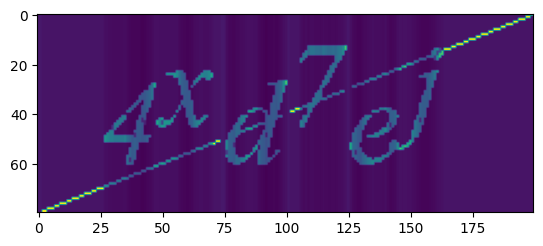

In [10]:
#preprocesss image  
n_letters = 6 ## No. of letter in Captcha

file =glob.glob(r"C:\Users\alokk\jarvis_dataset\Captcha_for_testing_2024\preprocess\*.png")

n = len(file)

X = np.zeros((n,image_width,image_length,1)) #1070*50*200 array with all entries 0

y = np.zeros((n,n_letters,nchar)) #5*1070*36(5 letters in captcha) with all entries 0

random.shuffle(file)

# print(file)

# Initialize X and y arrays
X = np.zeros((n, image_width, image_length, 1))  # Array with all entries 0

y = np.zeros((n, n_letters, nchar))  # Array with all entries 0

# Shuffle the file list
file = shuffle(file, random_state=42)

# Loop through each image in the folder
for i, pic in enumerate(file):
    
    img = cv2.imread(pic,cv2.IMREAD_GRAYSCALE)  # Read image in grayscale format
    # img=img[:,:,2]

    if img is not None:  # Check if the image is successfully loaded
        
        img = cv2.resize(img, (image_length, image_width), interpolation=cv2.INTER_AREA)
        
        pic_target = pic.split('\\')[-1][:-4]  # Drop the .png extension from the file name

        if len(pic_target) < 7:
            # Captcha is not more than n_letters
            scaler.fit(img) #scales the image between 0 and 1
            
            img = scaler.transform(img)
            
            img = np.reshape(img, (image_width,image_length,1)) #reshapes image to width 200 , height 50 ,channel 1
            
            target=np.zeros((n_letters,nchar))

            for j, k in enumerate(pic_target):
                
                index = character.find(k) #index stores the position of letter k of captcha in the character string
                
                target[j,index] = 1 #replaces 0 with 1 in the target array at the position of the letter in captcha

            plt.imshow(img)
            
            X[i] = img  # Stores green values only
            
            y[i,:] = target  # Set target to all 0, as only green values are considered
    else:
        print(f"Error loading image: {pic}")

In [11]:
#create model
def model():
    # create model
    model = keras.Sequential()
    # 1_conv
    model.add(keras.layers.Conv2D(32, (3, 3), padding="same",
                                      input_shape=imgshape))
    model.add(keras.layers.Activation("relu"))
    model.add(keras.layers.BatchNormalization(axis=-1))
    model.add(keras.layers.MaxPooling2D(pool_size=(3, 3)))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Conv2D(32, (3, 3), padding="same")) #64
    # 2_conv
    model.add(keras.layers.Activation("relu"))
    model.add(keras.layers.BatchNormalization(axis=-1))
    model.add(keras.layers.Conv2D(32, (3, 3), padding="same")) #64
    # 3_conv
    model.add(keras.layers.Activation("relu"))
    model.add(keras.layers.BatchNormalization(axis=-1))
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Conv2D(64, (3, 3), padding="same"))#128
    # 4_conv
    
    model.add(keras.layers.Activation("relu"))
    model.add(keras.layers.BatchNormalization(axis=-1))
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Conv2D(64, (3, 3), padding="same"))#128
    
    
    # 5_conv
    model.add(keras.layers.Activation("relu"))

    model.add(keras.layers.BatchNormalization(axis=-1))
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(keras.layers.Conv2D(128, (3, 3), padding="same"))#128
    model.add(keras.layers.Activation("relu"))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Flatten())
    # 1 dim
    
    model.add(keras.layers.Dense(2048))
    model.add(keras.layers.Activation("relu"))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(0.2))

    model.add(keras.layers.Dense(1024))
    model.add(keras.layers.Activation("relu"))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(0.2))
    model.add(layers.Dense(6*nchar,activation='relu'))
    model.add(tf.keras.layers.Reshape((6,nchar)))
    
    model.add(keras.layers.Dense(nchar))
    model.add(keras.layers.Activation("sigmoid"))
    
    #model = Model(img, outs) #create model
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-6,
    decay_steps=224,
    decay_rate=0.9)
    optimizer = tf.keras.optimizers.Nadam(learning_rate=1e-3)
    model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=optimizer,metrics=["accuracy"])
    return model

In [12]:
#Create model
model = model()
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 80, 200, 32)       320       
                                                                 
 activation (Activation)     (None, 80, 200, 32)       0         
                                                                 
 batch_normalization (Batch  (None, 80, 200, 32)       128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 26, 66, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 26, 66, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 66, 32)       

In [13]:
train_size = int(0.8 * n)
X_train, y_train = X[:train_size], y[:train_size,:]
X_test, y_test = X[train_size:], y[train_size:,:]

In [14]:
#early stopping
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30, min_delta=0.00001)

In [15]:
#model checkpoint
mc = ModelCheckpoint('epicid_model.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [16]:
#Applying the model
hist = model.fit(X_train, y_train, batch_size=32, epochs=100, validation_split=0.1,callbacks=[mc,es])

Epoch 1/100


221/221 [==============================] - ETA: 0s - loss: 2.8045 - accuracy: 0.2171
Epoch 1: val_accuracy improved from -inf to 0.13057, saving model to epicid_model.hdf5
221/221 [==============================] - 88s 357ms/step - loss: 2.8045 - accuracy: 0.2171 - val_loss: 4.1030 - val_accuracy: 0.1306
Epoch 2/100
221/221 [==============================] - ETA: 0s - loss: 0.9524 - accuracy: 0.7049
Epoch 2: val_accuracy improved from 0.13057 to 0.79915, saving model to epicid_model.hdf5
221/221 [==============================] - 77s 349ms/step - loss: 0.9524 - accuracy: 0.7049 - val_loss: 0.6154 - val_accuracy: 0.7992
Epoch 3/100
221/221 [==============================] - ETA: 0s - loss: 0.4352 - accuracy: 0.8836
Epoch 3: val_accuracy improved from 0.79915 to 0.93503, saving model to epicid_model.hdf5
221/221 [==============================] - 79s 359ms/step - loss: 0.4352 - accuracy: 0.8836 - val_loss: 0.2479 - val_accuracy: 0.9350
Epoch 4/100
221/221 [=================

KeyboardInterrupt: 

In [19]:
mc

In [ ]:
def predict(path,image_width,image_length):
    img = preprocess(path)
    img = cv2.imread('image.png',cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (image_length,image_width))
    
    if img is not None: #image foud at file path
        scaler.fit(img) #Scale image
        img = scaler.transform(img)
    else:
        print("Not detected");

    res = np.array(model.predict(img[np.newaxis, :, :, np.newaxis]))
    k_ind = []
    probs = []
    for i in res[0]:
        k_ind.append(np.argmax(i)) #adds the index of the char found in captcha

    capt = '' #string to store predicted captcha
    for k in k_ind:
        capt += character[k] #finds the char corresponding to the index
    return capt

In [ ]:
character= string.ascii_lowercase + "0123456789"
model = keras.models.load_model(r"C:\Users\alokk\Downloads\karnataka_captcha_Jan30\karnataka_captcha_Jan30.hdf5")

In [ ]:
# Sample prediction
path = r"C:\Users\alokk\jarvis_dataset\new_captcha_30-01-24\new\25.png"
txt = predict(path,80,200)
print(txt)